In [1]:
import cv2
import time
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

%matplotlib inline


In [2]:
# set the seed of the random number generator to reproduce the same results 
rand_seed = 0
np.random.seed(rand_seed)
torch.manual_seed(rand_seed)

In [3]:
# download prepared data and unzip it
!wget https://github.com/farisalasmary/adversarial-machine-learning-example/raw/master/mnist_data.zip
!unzip mnist_data.zip

--2022-07-16 04:25:57--  https://github.com/farisalasmary/adversarial-machine-learning-example/raw/master/mnist_data.zip
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/farisalasmary/adversarial-machine-learning-example/master/mnist_data.zip [following]
--2022-07-16 04:25:57--  https://raw.githubusercontent.com/farisalasmary/adversarial-machine-learning-example/master/mnist_data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15495916 (15M) [application/zip]
Saving to: ‘mnist_data.zip’

mnist_data.zip      100%[===================>]  14.78M  --.-KB/s    in 0.1s    

2022-07-16 04:25:57 (132 

# Training CNN model on MNIST dataset

In [4]:
# load MNIST data
train_data = pd.read_csv('mnist_train.csv')
test_data = pd.read_csv('mnist_test.csv')


In [5]:
train_data.head(5)

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


The label is: 3


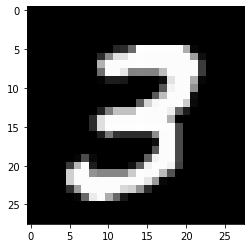

In [6]:
output = 'label' # labels column in the dataframe
features = list(train_data.columns)
features.remove(output)

image_with_label = train_data.iloc[7] # pick an example and show its image


label = image_with_label[output]
image = image_with_label[features].values

image = image.reshape(28, 28)

print('The label is:', label)
plt.imshow(image[0:784], cmap='gray')

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device: "{}"'.format(device))

Device: "cuda"


In [8]:
# convert data into PyTorch tensors
X_train = train_data[features].values
y_train = train_data[output].values

X_test = test_data[features].values
y_test = test_data[output].values

X_train = torch.tensor(X_train).float().to(device)
y_train = torch.tensor(y_train).float().to(device)
X_test = torch.tensor(X_test).float().to(device)
y_test = torch.tensor(y_test).float().to(device)

In [9]:
# data normalization
train_mean, train_std = X_train.mean(0), (X_train.std(0))
X_train = (X_train - train_mean) / (train_std + 1e-7)
X_test = (X_test - train_mean) / (train_std + 1e-7)

In [10]:
# return a mini batch of the given data with no. of examples = batch_size
def batch_generator(X, y, batch_size=64, device='cpu', shuffle=True):
    if shuffle:
        shuffled_indices = torch.randperm(X.size()[0])
        X = X[shuffled_indices, :]
        y = y[shuffled_indices]

    number_of_batches =  np.ceil(len(X) / batch_size).astype(int) # X_tensor.shape[0]
    for i in range(number_of_batches):
        X_mini_batch = X[i*batch_size : (i*batch_size + batch_size)]
        y_mini_batch = y[i*batch_size : (i*batch_size + batch_size)]

        yield X_mini_batch.reshape(len(X_mini_batch), 1, 28, 28).to(device), y_mini_batch.to(device)

In [11]:
# creating a CNN model. You may try to create your own m ,model and apply the code.
model = nn.Sequential(*[
            nn.Conv2d(1, 30, 3),
            nn.ReLU(),    
            nn.Conv2d(30, 40, 5),
            nn.ReLU(),
            nn.MaxPool2d(3),

            nn.Conv2d(40, 100, 3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(400, 100),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(100, 10)
])
model

Sequential(
  (0): Conv2d(1, 30, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): Conv2d(30, 40, kernel_size=(5, 5), stride=(1, 1))
  (3): ReLU()
  (4): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(40, 100, kernel_size=(3, 3), stride=(1, 1))
  (6): ReLU()
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): Dropout(p=0.5, inplace=False)
  (10): Linear(in_features=400, out_features=100, bias=True)
  (11): ReLU()
  (12): Dropout(p=0.5, inplace=False)
  (13): Linear(in_features=100, out_features=10, bias=True)
)

In [12]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


In [13]:
# use cross entropy loss
criterion = torch.nn.CrossEntropyLoss()

In [14]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)
avg_loss = AverageMeter()

In [15]:
batch_size = 64
epochs = 20
iteration = 1
model = model.to(device)
model.train()
for epoch in range(1, epochs + 1):
    for X_mini_batch, y_mini_batch in batch_generator(X_train, y_train, batch_size, device):
        # Forward Propagation
        y_pred = model(X_mini_batch) # Compute and print loss
        #loss = criterion(y_pred, y_mini_batch) # if we use MSELoss
        loss = criterion(y_pred, y_mini_batch.long()) # if we use CrossEntropyLoss
        avg_loss.update(loss.item(), X_mini_batch.size(0))
        if iteration % 100 == 0:
            print('epoch: ', epoch,' iteration: ', iteration, ' avg loss: ', avg_loss.val)    # Zero the gradients
        optimizer.zero_grad()

        # perform a backward pass (backpropagation)
        loss.backward()

        # Update the parameters
        optimizer.step()
        
        iteration += 1

epoch:  1  iteration:  100  avg loss:  1.2848687171936035
epoch:  1  iteration:  200  avg loss:  0.6270663738250732
epoch:  1  iteration:  300  avg loss:  0.5316914916038513
epoch:  1  iteration:  400  avg loss:  0.2796105444431305
epoch:  1  iteration:  500  avg loss:  0.3436203896999359
epoch:  1  iteration:  600  avg loss:  0.34926241636276245
epoch:  1  iteration:  700  avg loss:  0.44928857684135437
epoch:  1  iteration:  800  avg loss:  0.24121420085430145
epoch:  1  iteration:  900  avg loss:  0.12612499296665192
epoch:  2  iteration:  1000  avg loss:  0.18252795934677124
epoch:  2  iteration:  1100  avg loss:  0.27793240547180176
epoch:  2  iteration:  1200  avg loss:  0.07641780376434326
epoch:  2  iteration:  1300  avg loss:  0.12335626780986786
epoch:  2  iteration:  1400  avg loss:  0.16164161264896393
epoch:  2  iteration:  1500  avg loss:  0.08515890687704086
epoch:  2  iteration:  1600  avg loss:  0.3144090473651886
epoch:  2  iteration:  1700  avg loss:  0.3596653640270

In [16]:
def predict(x, model):
    with torch.no_grad():
        model.eval()
        softmax = nn.Softmax(1)
        y_pred = softmax(model(x))
    return y_pred.argmax(1)

In [17]:
# show the result of our model
y_pred = predict(X_test.reshape(len(X_test), 1, 28, 28), model).cpu().numpy()
print(classification_report(y_test.cpu().numpy(), y_pred))


              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       980
         1.0       0.99      0.99      0.99      1135
         2.0       0.99      0.99      0.99      1032
         3.0       0.99      1.00      0.99      1010
         4.0       1.00      0.99      0.99       982
         5.0       0.99      0.99      0.99       892
         6.0       1.00      0.99      0.99       958
         7.0       0.98      0.99      0.99      1028
         8.0       1.00      0.99      0.99       974
         9.0       0.99      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



In [18]:
def show_image(x, y_pred, y_true):
    print('The true label is:', y_true)
    print('The predicted label is:', y_pred)
    plt.imshow(x.reshape(28, 28), cmap='gray')

The true label is: 6.0
The predicted label is: 6


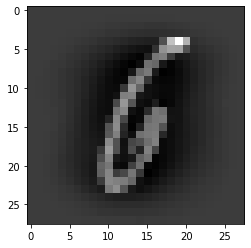

In [19]:
idx = 3344
show_image(X_test[idx].cpu().numpy(), y_pred[idx], y_test[idx].cpu().numpy())

# Adversarial Attack

In this section, we will select an image from the test set and use the freeze the paramters of our model. Instead of optimizing the paramters, we will optimize the input image such that the model maximizes the probability of the targeted label by modifying the input image.

In [20]:
def freeze_model(model, freeze=True):
    for param in model.parameters():
        param.requires_grad = not freeze

In [21]:
# Freeze the weights of the model.
# Also, set the model to eval mode to disable the dropout layers.
freeze_model(model, True)
model = model.eval()

The true label is: 8.0
The predicted label is: 8


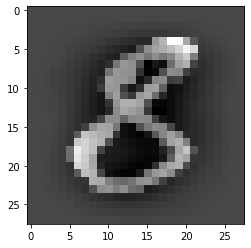

In [22]:
# targeted_y: the targted class that we want the model to predict given the 
#             image that we choose below after modification. This label will be 
#             predicted by the model after we create the adversarial image from 
#             the given image.
targeted_y = 4

# we choose a sample image from the test set to create the adversarial example
idx = 1234
sample_image = X_test[idx].clone().reshape(1, X_train.shape[1])
sample_y_pred = y_pred[idx]
sample_y_true = y_test[idx].clone().cpu().numpy()

targeted_y = torch.tensor([targeted_y]).long().to(device)
original_x = sample_image.detach().clone().reshape(1, 1, 28, 28).to(device)
x = torch.tensor(original_x.clone().cpu().numpy(), device=device, requires_grad=True)
show_image(sample_image.cpu().numpy(), sample_y_pred, sample_y_true)

In [23]:
# We create two objective functions: cross entropy and mean squared error.
# The cross entropy criterion will be used to maximize the probability of the
# targeted class and the mean squared error criterion is used to minimze the
# difference between the original image and the modified (adversarial) image.
criterion1 = nn.CrossEntropyLoss()
criterion2 = nn.MSELoss()

In [24]:
optimizer = torch.optim.SGD([x], lr=0.03)
avg_loss = AverageMeter()

In [25]:
epochs = 500000
iteration = 1
batch_size = 1

for epoch in range(1, epochs + 1):
    # Forward Propagation
    targeted_y_pred = model(x) # Compute and print loss
    #loss = criterion1(targeted_y_pred, targeted_y)    # Loss WITHOUT minimizing the difference between the original image and the synthesized image
    loss = criterion1(targeted_y_pred, targeted_y) + criterion2(x, original_x)   # Loss WITH minimizing the difference between the original image and the synthesized image
    avg_loss.update(loss.item(), x.size(0))
    if iteration % 10000 == 0:
        print('epoch: ', epoch,' iteration: ', iteration, ' avg loss: ', avg_loss.val)   
    
    # Zero the gradients
    optimizer.zero_grad()

    # perform a backward pass (backpropagation)
    loss.backward()

    # Update the parameters
    optimizer.step()

    iteration += 1

epoch:  10000  iteration:  10000  avg loss:  0.09198906272649765
epoch:  20000  iteration:  20000  avg loss:  0.08399336785078049
epoch:  30000  iteration:  30000  avg loss:  0.08074918389320374
epoch:  40000  iteration:  40000  avg loss:  0.07965526729822159
epoch:  50000  iteration:  50000  avg loss:  0.07900606095790863
epoch:  60000  iteration:  60000  avg loss:  0.07872308045625687
epoch:  70000  iteration:  70000  avg loss:  0.07859789580106735
epoch:  80000  iteration:  80000  avg loss:  0.07854384183883667
epoch:  90000  iteration:  90000  avg loss:  0.0779203549027443
epoch:  100000  iteration:  100000  avg loss:  0.07765548676252365
epoch:  110000  iteration:  110000  avg loss:  0.07752396166324615
epoch:  120000  iteration:  120000  avg loss:  0.07742372155189514
epoch:  130000  iteration:  130000  avg loss:  0.07726088911294937
epoch:  140000  iteration:  140000  avg loss:  0.0770735964179039
epoch:  150000  iteration:  150000  avg loss:  0.07698501646518707
epoch:  160000 

In [26]:
# get the model prediction of both the original image and the adversarial image.
y_pred_original = predict(original_x, model)
y_pred_adversarial = predict(x, model)
y_pred_original, y_pred_adversarial

(tensor([8], device='cuda:0'), tensor([4], device='cuda:0'))

The true label is: 8.0
The predicted label is: [8]


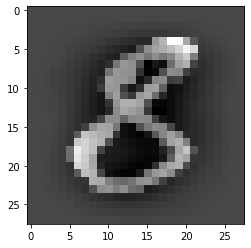

In [29]:
# Show the original image
show_image(original_x.detach().clone().cpu().numpy(), y_pred_original.clone().cpu().numpy(), sample_y_true)

The true label is: 8.0
The predicted label is: [4]


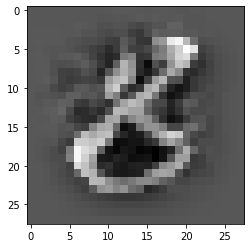

In [30]:
# Show the adversarial image
show_image(x.detach().clone().cpu().numpy(), y_pred_adversarial.clone().cpu().numpy(), sample_y_true)